In [94]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'conv1d.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd4/rwG2zPYz5nLw4oxBo_eyUAEiKbHKef-aAv0iLRHPbfc_HJc1tMyuWYo

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
./conv1d.ipynb

/bin/bash: pwd4/rwG2zPYz5nLw4oxBo_eyUAEiKbHKef-aAv0iLRHPbfc_HJc1tMyuWYo: No such file or directory


In [0]:
import torch
import torch.nn as nn
import numpy as np
import time
import torch.nn.functional as F
import random
from matplotlib import pyplot as plt

In [96]:
trainer=np.load("trainData__SMOTE_all_10s_f4.npz","rb")
tester=np.load("trainData__SMOTE_all_10s_f4_TEST.npz", "rb")

x_train=torch.from_numpy(trainer['x'][:])
y_train=torch.from_numpy(trainer['y'][:])
y_train=y_train.long()

x_test=torch.from_numpy(tester['x'][:])
y_test=torch.from_numpy(tester['y'][:])
y_test=y_test.long()

print("Training data size= ",x_train.size(), "\t\tTraining label size= ",y_train.size(),sep="\t")
print("Testing data size= ", x_test.size(), "\t\tTesting label size= ", y_test.size(),sep="\t")

#REshape x_test and y_test into x_train and y_train dimensions

x_test=x_test.view(-1,3000)
y_test=y_test.view(-1,)

print("\n\nReshaped Testing data size= ", x_test.size(), "\t\tReshaped Testing label size= ", y_test.size(),sep="\t")

Training data size= 	torch.Size([57695, 3000])			Training label size= 	torch.Size([57695])
Testing data size= 	torch.Size([2104, 1, 3000])			Testing label size= 	torch.Size([2104, 1])


Reshaped Testing data size= 	torch.Size([2104, 3000])			Reshaped Testing label size= 	torch.Size([2104])


In [97]:
std= x_train.std()
mean=x_train.mean()
batch_size = 100
learning_rate = 0.01
range_val=len(x_train)-batch_size

print(std,mean,sep="  ")

tensor(0.9643)  tensor(7.3141e-10)


In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        #Pool and activation fn's here 
        activation=nn.ReLU()       
        pool_8 = nn.MaxPool1d(kernel_size=8,stride=8) #Size=8
        pool_4 = nn.MaxPool1d(kernel_size=4,stride=4) #Size=4
        pool_2 = nn.MaxPool1d(kernel_size=2,stride=2) #Size=2
        
        #Dropout
        self.drop_out = nn.Dropout()
        
        
        #ConvNet time
        conv1_t=nn.Conv1d (1, 64, kernel_size=50,stride=6,padding=1)
        self.conv2_t=nn.Conv1d(64,128,kernel_size=8,stride=1,padding=1)
        self.conv3_t=nn.Conv1d(128,128,kernel_size=8,stride=1,padding=1)
        conv4_t=nn.Conv1d(128,128,kernel_size=8,stride=1,padding=1)
        
        #Layers time
        self.layer1_t=nn.Sequential(conv1_t,activation,pool_8)
        self.layer2_t=nn.Sequential(conv4_t,activation,pool_4)
        
        #ConvNet freq
        
        conv1_f=nn.Conv1d(1,  64,  kernel_size=400, stride=50,padding=1)
        self.conv2_f=nn.Conv1d(64, 128, kernel_size=6,   stride=1,padding=1)
        self.conv3_f=nn.Conv1d(128,128, kernel_size=6,   stride=1,padding=1)
        conv4_f=nn.Conv1d(128,128, kernel_size=6,   stride=1,padding=1)
        
        
        #Layers freq
        
        self.layer1_f=nn.Sequential(conv1_f, activation, pool_4)
        self.layer2_f=nn.Sequential(conv4_f, activation, pool_2)
        
        self.layer=nn.Sequential(nn.Linear(1664,5,bias=False),activation)
        
        
   
    def forward(self,x):
        
        
        #Time here
        out_t=self.layer1_t(x)
        out_t=self.drop_out(out_t)  #DropOut
        out_t=self.conv2_t(out_t)
        out_t=self.conv3_t(out_t)
        out_t=self.layer2_t(out_t)
        
        #Freq here
        
        out_f=self.layer1_f(x)
        out_f=self.drop_out(out_f)  #DropOut
        out_f=self.conv2_f(out_f)
        out_f=self.conv3_f(out_f)
        out_f=self.layer2_f(out_f)
        
        out=torch.cat((out_t,out_f),2)  #Concat
        out=self.drop_out(out)   #DropOut
       # print(out.size())
        out=out.view(-1,1664)
        
        out=self.layer(out)
        return out

In [99]:
net=ConvNet()
print(net)
net = net.to(torch.device("cuda"))

mean=mean.to(torch.device("cuda"))

std=std.to(torch.device("cuda"))
criterion = nn.CrossEntropyLoss()

ConvNet(
  (drop_out): Dropout(p=0.5, inplace=False)
  (conv2_t): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(1,))
  (conv3_t): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(1,))
  (layer1_t): Sequential(
    (0): Conv1d(1, 64, kernel_size=(50,), stride=(6,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_t): Sequential(
    (0): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_f): Conv1d(64, 128, kernel_size=(6,), stride=(1,), padding=(1,))
  (conv3_f): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(1,))
  (layer1_f): Sequential(
    (0): Conv1d(1, 64, kernel_size=(400,), stride=(50,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_f): Sequential(
    (0): Conv1d(128, 1

In [0]:
def get_error(scores,labels):
  
  batch_size = scores.size(0)
  predicted_labels = scores.argmax(dim=1)
  indicator = (predicted_labels == labels)
  num_matches=indicator.sum()
  
  return 1-num_matches.float()/batch_size

In [0]:
def eval_on_test_set(error_axis_test):

    running_error=0
    num_batches=0

    for i in range(0,len(x_test)-batch_size,batch_size):

        minibatch_data =  x_test[i:i+batch_size].unsqueeze(dim=1)
        minibatch_label= y_test[i:i+batch_size]

        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std  

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    error_axis_test.append(total_error*100)
    print( 'error rate on test set =', total_error*100 ,'percent')
    return error_axis_test

In [102]:
start=time.time()
epoch_axis_train=list()
error_axis_train=list()

error_axis_test=list()
epoch_axis_test=list()


for epoch in range(1,200):
    if epoch%100==0:
      learning_rate=learning_rate/2
       
    optimizer=torch.optim.SGD( net.parameters() , lr=learning_rate )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(range_val)
 
    for count in range(0,range_val,batch_size):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+batch_size]
        minibatch_data =  x_train[indices].unsqueeze(dim=1)
        minibatch_label=  y_train[indices]
        
        #print("minibatch_data= ",minibatch_data.size())
        #print("minibatch_label= ",minibatch_label.size())
        
        
        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std      
        
        inputs.requires_grad_()
                
        scores=net( inputs ) 
        #print("SCores=", scores.size())

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

               
        running_loss += loss.detach().item()
        
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
          
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    if epoch%20==0:
      print('epoch=',epoch, '\t time=', elapsed,'min', '\t learning rate=', learning_rate  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
      error_axis_test = eval_on_test_set(error_axis_test)
      epoch_axis_test.append(epoch)
      print(' ')
      
    epoch_axis_train.append(epoch)
    error_axis_train.append(error*100)

epoch= 20 	 time= 4.153123644987742 min 	 learning rate= 0.01 	 loss= 0.48440004895544714 	 error= 18.56405541507734 percent
error rate on test set = 21.904764005116053 percent
 
epoch= 40 	 time= 8.289548416932425 min 	 learning rate= 0.01 	 loss= 0.4309104787341009 	 error= 16.472133031735815 percent
error rate on test set = 21.285716692606606 percent
 
epoch= 60 	 time= 12.422879306475322 min 	 learning rate= 0.01 	 loss= 0.39650918419162434 	 error= 14.735473495804602 percent
error rate on test set = 21.000002111707413 percent
 
epoch= 80 	 time= 16.48282806078593 min 	 learning rate= 0.01 	 loss= 0.36410401823620003 	 error= 13.56515178663863 percent
error rate on test set = 24.71428712209066 percent
 
epoch= 100 	 time= 20.613182934125266 min 	 learning rate= 0.005 	 loss= 0.32843000752230483 	 error= 12.205959597809448 percent
error rate on test set = 21.666669561749412 percent
 
epoch= 120 	 time= 24.759062345822652 min 	 learning rate= 0.005 	 loss= 0.3137439588058947 	 error=

# Training set plots

Mean error on train set= 13.721234 % 



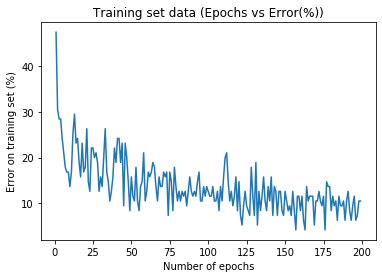

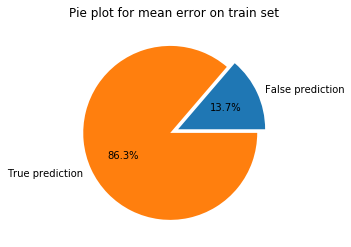

In [103]:
l=list()
for i in error_axis_train:
  l.append(i.cpu().detach().numpy())

mean=np.mean(l)
print("Mean error on train set=",mean,"% \n")
plt.plot(epoch_axis_train,error_axis_train)
plt.title("Training set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on training set (%)")
plt.show()
explode=(0.05,0.05)

print("\n")
labels=["False prediction","True prediction"]
plt.pie([mean,100-mean],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for mean error on train set")
plt.show()

# Test set plots

Mean error on test set= 22.269843400470794 % 



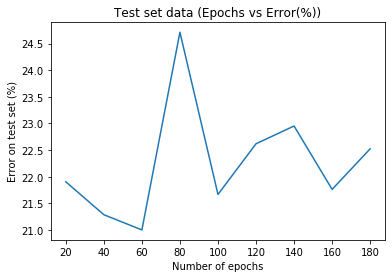

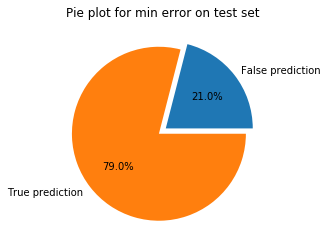

In [104]:
print("Mean error on test set=",np.mean(error_axis_test),"% \n")
plt.plot(epoch_axis_test,error_axis_test)
plt.title("Test set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on test set (%)")
plt.show()
print("\n")
plt.pie([min(error_axis_test),100-min(error_axis_test)],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for min error on test set")
plt.show()